# Histogram of Curvature Scale Implementation:

In [98]:
import numpy as np
import skimage.io as io
import skimage.morphology as morph
import skimage.feature as feat
import skimage.measure as measure
import matplotlib.pyplot as plt
import skimage.segmentation as seg

def find_edge_coordinates(B):
    boundaries = seg.find_boundaries(B, connectivity = 1, mode = 'inner')
    edge_coordinates = np.where(boundaries > 0)
    edge_coordinates = np.transpose(np.vstack(edge_coordinates))
    return edge_coordinates

def find_curvature(B, edge_coordinates, radius, num_bins, increment):
    k_p_values = []
    
    for coordinates in edge_coordinates:
        y_coord = coordinates[0]
        x_coord = coordinates[1]
        
        disk = morph.disk(radius)
        original_values = B[y_coord - radius : y_coord + radius + 1, x_coord - radius : x_coord + radius + 1]
        region_values = np.where(disk, original_values, 0)
        
        L = morph.label(region_values > 0)
        props = measure.regionprops(L)
        
        k_p = 0
        if len(props) > 0:
            area_c_r = props[0]['area_filled']
            area_c = np.pi * (radius ** 2)
            k_p = area_c_r / area_c

        k_p_values.append(k_p)

    hist, unused = np.histogram(k_p_values, bins = num_bins, range=(0, 1))
    hist = hist / np.sum(hist)
    
    return hist

def HoCS(B, min_scale, max_scale, increment, num_bins):
    histograms = []
    
    B = np.pad(B, pad_width = max_scale + increment, mode = 'constant', constant_values = 0)
    edge_coordinates = find_edge_coordinates(B)
    
    for scale in range(min_scale, max_scale + 1, increment):
        histogram = find_curvature(B, edge_coordinates, scale, num_bins, increment)
        histograms.extend(histogram)
        
    return histograms

#------TEST-------
# min_scale = 5
# max_scale = 25
# increment = 10
# num_bins = 10
# img = io.imread('./MPEG7dataset/pngs/apple-1.png', as_gray = True)
# print(img.shape)
# hist = HoCS(img, min_scale, max_scale, increment, num_bins)

# Testing the HoCS function:

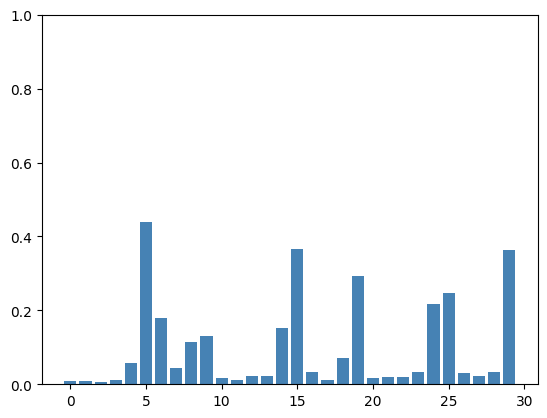

In [99]:
import skimage.io as io
%matplotlib inline

min_scale = 5
max_scale = 25
increment = 10
num_bins = 10

img = io.imread('./MPEG7dataset/training-set/bird-3.png', as_gray = True)
histogram = HoCS(img, min_scale, max_scale, increment, num_bins)

plt.bar(np.arange(max_scale + min_scale), histogram, color = 'steelblue', align = 'center')

plt.ylim(0, 1)
plt.show()

# Calculating training features:

In [119]:
import os as os
import pandas as pd

with open('./MPEG7dataset/categories.txt', 'r') as file:
    CATEGORIES = [line.strip() for line in file if line.strip()]

category_to_label = {cat: idx + 1 for idx, cat in enumerate(CATEGORIES)}

trainingSetDir = './MPEG7dataset/training-set/'
min_scale = 1
max_scale = 30
increment = 5
num_bins = 10

training_files = [f for f in os.listdir(trainingSetDir) if f.endswith('.png')]

descriptorsArray = []
training_labels = []

for i, file_name in enumerate(training_files):
    category = file_name.split('-')[0]
    
    if category not in category_to_label:
        continue

    label = category_to_label[category]

    img_path = os.path.join(trainingSetDir, file_name)
    img = io.imread(img_path, as_gray = True)
    histograms = HoCS(img, min_scale, max_scale, increment, num_bins)

    descriptorsArray.append(histograms)
    training_labels.append(label)
    
print('DONE')

KeyboardInterrupt: 

# Training the KNN classifier using the extracted feature vectors:

In [114]:
import sklearn.neighbors as neigh

knn = neigh.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn.fit(descriptorsArray, training_labels)

KNeighborsClassifier(weights='distance')

# Calculating the testing features:

In [116]:
import os as os
import pandas as pd

testingSetDir = './MPEG7dataset/testing-set/'

testing_files = [f for f in os.listdir(testingSetDir) if f.endswith('.png')]

descriptorsTestingArray = []
testing_labels = []

for i, file_name in enumerate(testing_files):
    category = file_name.split('-')[0]
    
    if category not in category_to_label:
        continue
    else:
        label = category_to_label[category]

    img_path = os.path.join(testingSetDir, file_name)
    img = io.imread(img_path, as_gray=True)
    histograms = HoCS(img, min_scale, max_scale, increment, num_bins)

    descriptorsTestingArray.append(histograms)
    testing_labels.append(label)

print('DONE')

DONE


# Classfying the testing features:

In [117]:
import sklearn.neighbors as neigh
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict
y_pred = knn.predict(descriptorsTestingArray)
y_true = np.array(testing_labels)

conf_matrix = confusion_matrix(y_true, y_pred)
classification_rate = np.trace(conf_matrix) / len(y_true)

print("Classification Rate:", classification_rate)
print("Confusion Matrix:\n", conf_matrix)

Classification Rate: 1.0
Confusion Matrix:
 [[3 0 0]
 [0 3 0]
 [0 0 3]]
